<a href="https://colab.research.google.com/github/drempe/COVID-19-Travis-County-and-Texas/blob/master/COVID_in_Travis_County_and_Texas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**COVID 19 Data for Travis County and Texas **



Data sources: 
https://covidtracking.com/data/



https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_daily_reports/

Texas/travis county: 
https://www.arcgis.com/home/webmap/viewer.html?url=https://services5.arcgis.com/ACaLB9ifngzawspq/ArcGIS/rest/services/COVID19County_ViewLayer/FeatureServer/0&source=sd

https://austin.maps.arcgis.com/apps/opsdashboard/index.html#/39e4f8d4acb0433baae6d15a931fa984

https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_daily_reports/03-25-2020.csv


mobility data: 

https://www.unacast.com/covid19/social-distancing-scoreboard


Modeling report for Austin: 
https://utexas.app.box.com/s/7kgikqmev8ex831aq9wcsb3n5kwr7nxh

modeling papers and sites: 

https://covidactnow.org/state/CO

https://medium.com/@tomaspueyo/coronavirus-act-today-or-people-will-die-f4d3d9cd99ca

http://sci-hub.tw/10.1016/S2468-2667(20)30073-6

https://www.sciencemag.org/news/2020/03/mathematics-life-and-death-how-disease-models-shape-national-shutdowns-and-other


ventilator and ICU bed availability data: 

from U\rationalanarchy post: Total number of ICU beds in 5 county area. (750 Thanks /u/xxxyyyzzz555 )Total number of ventilators in 5 county area. (750 Thanks /u/xxxyyyzzz555 ) Total number of hospitalizations in Travis county. (Edit: The Deputy Medical Director of Travis County said there were only 3 hospitalizations as of 3 days ago. )


In [0]:
#@title various data csv or json sources 
# df=pd.read_json('https://covidtracking.com/api/states/daily?state=TX')
# df=pd.read_csv('https://covidtracking.com/api/us/daily.csv')
df=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/03-28-2020.csv', error_bad_lines=False)
# df.index = pd.to_datetime(df.dateChecked)

In [0]:
#@title Import required libraries
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
matplotlib.rcParams.update({'font.size': 8})
import pandas as pd
import numpy as np
import scipy as scipy

%matplotlib inline
import matplotlib.dates as mdates
plt.rcParams["font.sans-serif"] = "Futura"
from datetime import datetime, date
from scipy.io import loadmat 
import datetime as dt
from scipy import signal
from functools import reduce
import os
from google.colab import files
import functools 

from scipy import optimize
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.ticker as ticker


### **TRAVIS COUNTY**

In [0]:
# @title download COVID county data for US and county population 
df=pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
df.date = pd.to_datetime(df.date)

popdat=pd.read_csv('https://demographics.texas.gov/Resources/TPEPP/Estimates/2018/2018_txpopest_county.csv')

Text(0, 0.5, 'COVID Positive deaths')

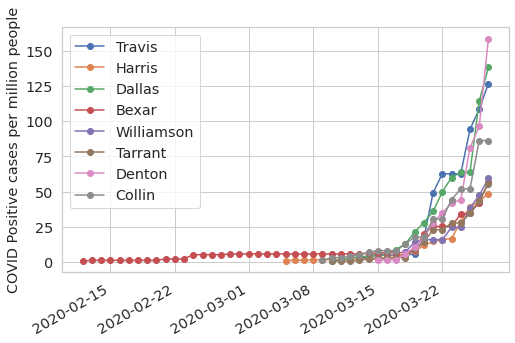

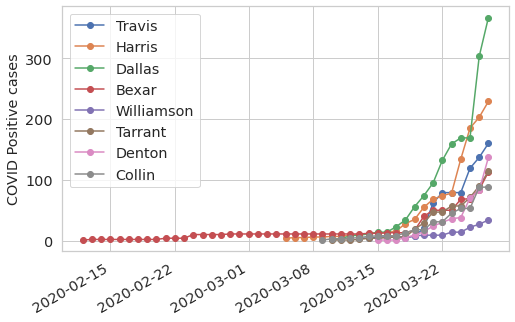

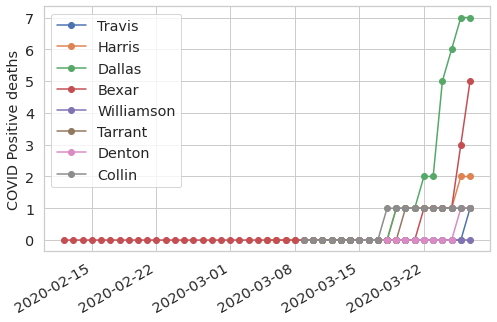

In [279]:
#@title counties in TX
 
# pop = [1.24,4.63, 2.618, 1.959, 0.527, 2.019,0.807, 0.944]
county = ['Travis','Harris','Dallas','Bexar', 'Williamson','Tarrant','Denton','Collin']

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


fig, ax = plt.subplots(1,figsize=(8,5))

for ct in county:
  date=df[(df['county']==ct)&(df['state']=='Texas')]['date']
  cases = df[(df['county']==ct)&(df['state']=='Texas')]['cases']
  pop = popdat[popdat['county']==ct]['jan1_2019_pop_est'].values
  popinmill=pop/1e6
  cases_per_pop = [x/popinmill for x in cases]
  # print(cases_per_pop)
  plt.plot(date,cases_per_pop,label=ct,marker='o')

fig.autofmt_xdate()
ax.legend()
ax.set_ylabel('COVID Positive cases per million people')

fig, ax = plt.subplots(1,figsize=(8,5))

for ct in county:
  date=df[(df['county']==ct)&(df['state']=='Texas')]['date']
  cases = df[(df['county']==ct)&(df['state']=='Texas')]['cases']
  plt.plot(date,cases,label=ct,marker='o')

fig.autofmt_xdate()
ax.legend()
ax.set_ylabel('COVID Positive cases')

fig, ax = plt.subplots(1,figsize=(8,5))

for ct in county:
  date=df[(df['county']==ct)&(df['state']=='Texas')]['date']
  cases = df[(df['county']==ct)&(df['state']=='Texas')]['deaths']
  plt.plot(date,cases,label=ct,marker='o')

fig.autofmt_xdate()
ax.legend()
ax.set_ylabel('COVID Positive deaths')



Text(0.5, 0, 'Elapsed time (days)')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


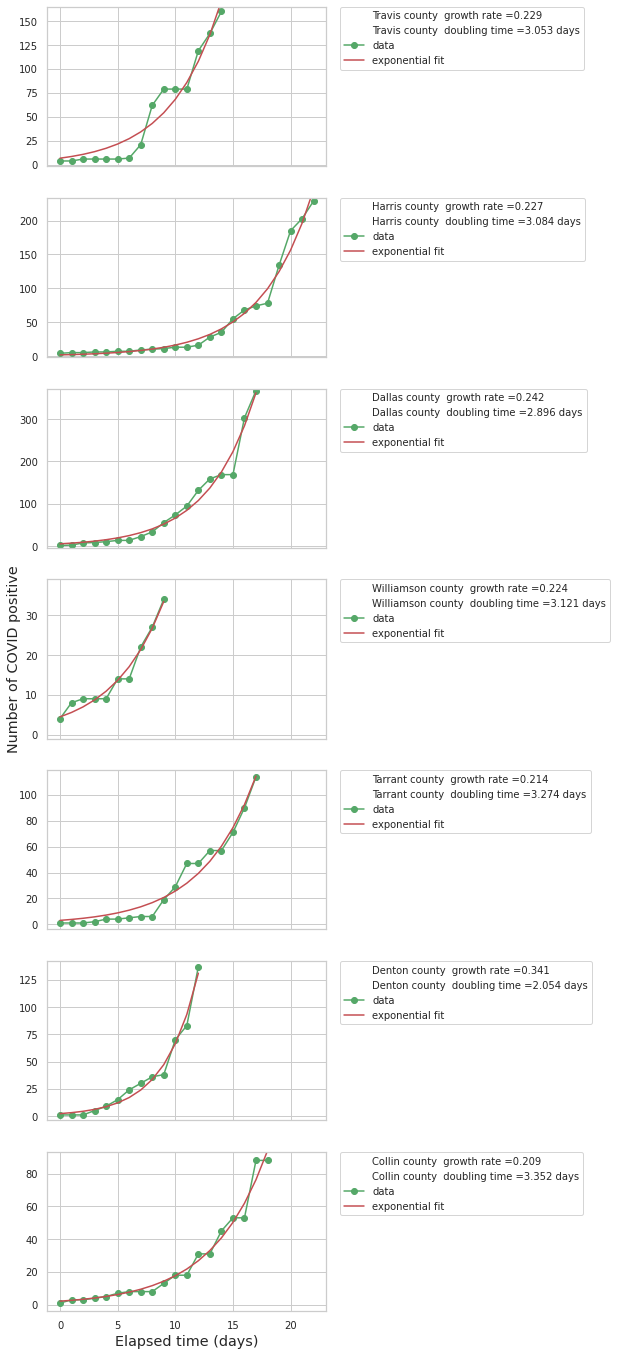

In [280]:
#@title texas county growth rates
# county = ['Travis','Bexar','Williamson','Hays']
# county=['Travis','Bexar']
county = ['Travis','Harris','Dallas', 'Williamson','Tarrant','Denton','Collin']

params = {'legend.fontsize': 'medium',
          'figure.figsize': (5, 24),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
plt.rcParams.update(params)


def func(x, a, b):
    return a*np.exp(b*(x))


fig, ax = plt.subplots(len(county),sharex=True,sharey=False)

for i,ct in zip(range(len(county)),  county):
  date=df[(df['county']==ct)&(df['state']=='Texas')]['date']
  cases = df[(df['county']==ct)&(df['state']=='Texas')]['cases']
  pop = popdat[popdat['county']==ct]['jan1_2019_pop_est'].values
  popinmill=pop/1e6
  cases_per_pop = [x/popinmill for x in cases]
  # print(cases_per_pop)
  x_data = mdates.date2num(date)
  x = x_data-np.min(x_data)
  y = cases.values
  popt, pcov = curve_fit(func, x,y)
  # popt, pcov = curve_fit(func, x, y, [1,1])
  
  ax[i].plot([], [], ' ', label=ct+' county  growth rate ='+ str(round(popt[1],3))) 
  ax[i].plot([], [], ' ', label=ct+' county  doubling time ='+ str(round(70/(100*popt[1]),3))+ ' days') 

  ax[i].set_ylim(min(y)-5,max(y)+5)
  ax[i].plot(x,y,marker='o',label='data')
  ax[i].plot(x,func(x,*popt),label='exponential fit')
  ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax[int(int(len(county))/2)].set_ylabel('Number of COVID positive')

ax[i].set_xlabel('Elapsed time (days)')
# fig.autofmt_xdate()
# ax.set_ylabel('COVID Positive cases per million people')

# x_data = mdates.date2num(travis_date)
# x_data = x_data-np.min(x_data)
# y_data = travis_positive

# x = x_data
# y = y_data

# def func(x, a, b):
#     return a*np.exp(b*(x))

# popt, pcov = curve_fit(func, x,y)
# # popt, pcov = curve_fit(func, x, y, [1,1])
# print(popt)


# fig, ax = plt.subplots(1,figsize=(6,4))
# plt.plot(x,y,label='travis county data',marker='o')
# plt.plot(x,func(x,*popt),label='exponential fit')
# ax.set_xlabel('Elapsed time (days)')
# ax.set_ylabel('Number of COVID positive')
# ax.set_title('Travis County')
# plt.plot([], [], ' ', label='growth rate ='+ str(round(popt[1],3)))
# ax.legend()
# ax.grid()
# show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


[1.54337136 0.30286027]


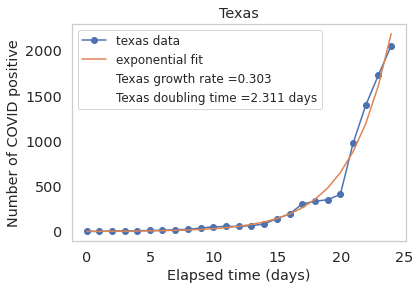

Text(0.5, 1.0, 'Texas')

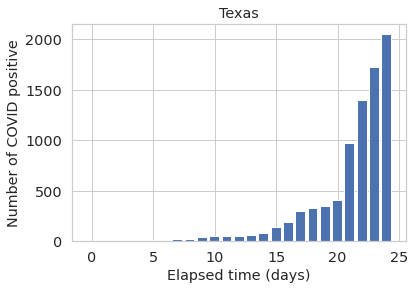

In [281]:
#@title Growth rate 
from pylab import *
from scipy.optimize import curve_fit


params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)



# x_data = mdates.date2num(travis_date)
# x_data = x_data-np.min(x_data)
# y_data = travis_positive

# x = x_data
# y = y_data

# def func(x, a, b):
#     return a*np.exp(b*(x))

# popt, pcov = curve_fit(func, x,y)
# # popt, pcov = curve_fit(func, x, y, [1,1])
# print(popt)


# fig, ax = plt.subplots(1,figsize=(6,4))
# plt.plot(x,y,label='travis county data',marker='o')
# plt.plot(x,func(x,*popt),label='exponential fit')
# ax.set_xlabel('Elapsed time (days)')
# ax.set_ylabel('Number of COVID positive')
# ax.set_title('Travis County')
# plt.plot([], [], ' ', label='growth rate ='+ str(round(popt[1],3)))
# ax.legend()
# ax.grid()
# show()


df=pd.read_json('https://covidtracking.com/api/states/daily?state=TX')
# df=pd.read_csv('https://covidtracking.com/api/us/daily.csv')
df.index = pd.to_datetime(df.dateChecked)

x_data = mdates.date2num(df.index)
x_data = x_data-np.min(x_data)
y_data = df.positive

x = x_data
y = y_data

def func(x, a, b):
    return a*np.exp(b*(x))

popt, pcov = curve_fit(func, x,y)
# popt, pcov = curve_fit(func, x, y, [1,1])
print(popt)


fig, ax = plt.subplots(1,figsize=(6,4))
plt.plot(x,y,label='texas data',marker='o')
x=x_data
plt.plot(x,func(x,*popt),label='exponential fit')
# plt.plot(x,popt[0]*np.exp(popt[1]*(x)))
ax.set_xlabel('Elapsed time (days)')
ax.set_ylabel('Number of COVID positive')
ax.set_title('Texas')
plt.plot([], [], ' ', label='Texas growth rate ='+ str(round(popt[1],3))) 
plt.plot([], [], ' ', label='Texas doubling time ='+ str(round(70/(100*popt[1]),3))+ ' days') 

ax.legend()
ax.grid()
show()


fig, ax = plt.subplots(1,figsize=(6,4))
plt.bar(x,y)
ax.set_xlabel('Elapsed time (days)')
ax.set_ylabel('Number of COVID positive')
ax.set_title('Texas')

([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text major ticklabel objects>)

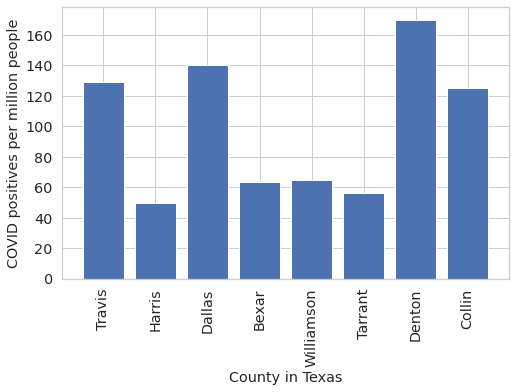

In [282]:
#@title DEPRECATED manual calc of texas county positives per population 


params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fig, ax = plt.subplots(1,figsize=(8,5))
# data manually collected from: https://www.arcgis.com/home/webmap/viewer.html?url=https://services5.arcgis.com/ACaLB9ifngzawspq/ArcGIS/rest/services/COVID19County_ViewLayer/FeatureServer/0&source=sd
# and populations from wikipedia


cases_03_26 = [119,185,303,84, 22, 90, 70 , 53]
cases_03_27 = [137,203, 367, 113, 27, 100, 83, 88]
cases_03_28 = [160,229,367,125,34,114,137,118]
pop = [1.24,4.63, 2.618, 1.959, 0.527, 2.019,0.807, 0.944]
county = ['Travis','Harris','Dallas','Bexar', 'Williamson','Tarrant','Denton','Collin']

cases_per_pop = [x/y for x, y in zip(cases_03_28, pop)]
plt.bar(county,cases_per_pop)
ax.set_ylabel('COVID positives per million people')
ax.set_xlabel('County in Texas')
plt.xticks(rotation=90)


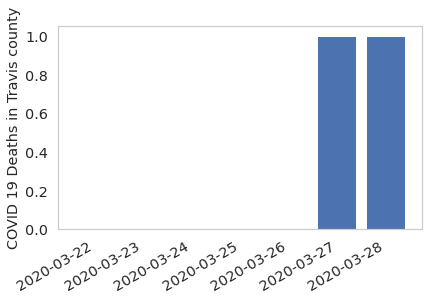

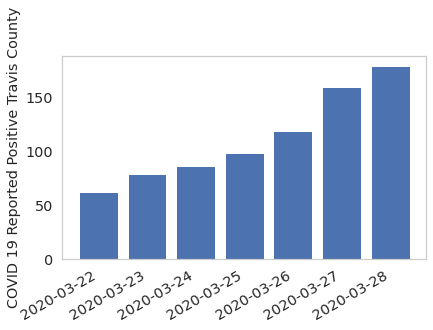

In [283]:
#@title DEPRECATED manually collected data for travis county

# Data manually collected from: 
# https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_daily_reports/03-25-2020.csv
# : https://www.arcgis.com/home/webmap/viewer.html?url=https://services5.arcgis.com/ACaLB9ifngzawspq/ArcGIS/rest/services/COVID19County_ViewLayer/FeatureServer/0&source=sd

travis_date=[pd.datetime(2020,3,22),pd.datetime(2020,3,23),pd.datetime(2020,3,24),pd.datetime(2020,3,25),pd.datetime(2020,3,26),pd.datetime(2020,3,27),pd.datetime(2020,3,28)]
travis_positive=[62, 79, 86, 98, 119, 160, 179]
travis_death=[0,0,0,0,0, 1,1]


params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fig, ax = plt.subplots(1,figsize=(6,4))
# fig,ax = plt.subplots(len(tdt_normalized.columns),1,figsize=(11,8.5),sharex=True)

plt.bar(travis_date, travis_death)
fig.autofmt_xdate()
plt.tight_layout()
ax.set_ylabel('COVID 19 Deaths in Travis county')
# plt.show()
ax.grid()


fig, ax = plt.subplots(1,figsize=(6,4))
# fig,ax = plt.subplots(len(tdt_normalized.columns),1,figsize=(11,8.5),sharex=True)

plt.bar(travis_date, travis_positive)
fig.autofmt_xdate()
plt.tight_layout()
ax.set_ylabel('COVID 19 Reported Positive Travis County')
ax.grid()



## **TEXAS**

In [0]:
df=pd.read_json('https://covidtracking.com/api/states/daily?state=TX')
# df=pd.read_csv('https://covidtracking.com/api/us/daily.csv')
df.index = pd.to_datetime(df.dateChecked)

In [285]:
df.head()

,date,state,positive,negative,pending,hospitalized,death,total,hash,dateChecked,totalTestResults,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
dateChecked,,,,,,,,,,,,,,,,,
2020-03-28 20:00:00+00:00,20200328,TX,2052,23208.0,NaN,NaN,27.0,25260,99dfc03ce154cf5e62e21acc97fd188c2d5d6a44,2020-03-28T20:00:00Z,25260,48,4.0,0.0,1273.0,321.0,1594.0
2020-03-27 20:00:00+00:00,20200327,TX,1731,21935.0,NaN,NaN,23.0,23666,4f9689bbee1981b2c94c62ca7394e4db47ba2aef,2020-03-27T20:00:00Z,23666,48,5.0,0.0,1907.0,335.0,2242.0
2020-03-26 20:00:00+00:00,20200326,TX,1396,20028.0,NaN,NaN,18.0,21424,33ac609e1f7bd911f98af6f86d2ae80cce029686,2020-03-26T20:00:00Z,21424,48,6.0,0.0,7508.0,422.0,7930.0
2020-03-25 20:00:00+00:00,20200325,TX,974,12520.0,NaN,NaN,12.0,13494,91d17b89756a65686fbeadadea6a1af6640d2eae,2020-03-25T20:00:00Z,13494,48,3.0,0.0,1763.0,564.0,2327.0
2020-03-24 20:00:00+00:00,20200324,TX,410,10757.0,NaN,NaN,9.0,11167,6e356268de7eaca86322ddd2bb190418d8e43cbf,2020-03-24T20:00:00Z,11167,48,1.0,0.0,1054.0,58.0,1112.0


Text(0, 0.5, 'COVID 19 Fraction of Tests reported Positive')

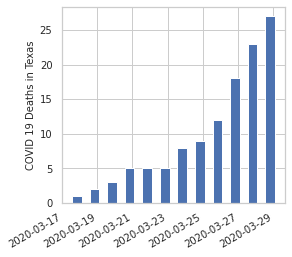

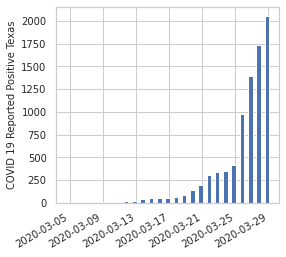

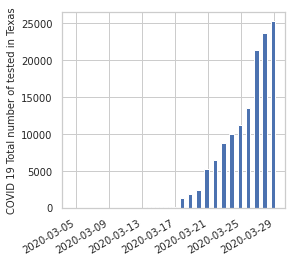

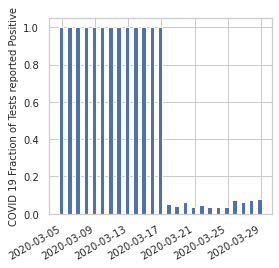

In [286]:
#@title texas stats

params = {'legend.fontsize': 'medium',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
plt.rcParams.update(params)

fig, ax = plt.subplots()
width = 0.55  # the width of the bars
rects1 = ax.bar(df.index , df.death, width, label='reported positive')
# rects2 = ax.bar(df.index , df.positive*27, width, label='probable positive')
ax.xaxis_date()
fig.autofmt_xdate()
ax.set_ylabel('COVID 19 Deaths in Texas')

fig, ax = plt.subplots()
width = 0.55  # the width of the bars
rects1 = ax.bar(df.index , df.positive, width, label='reported positive')
# rects2 = ax.bar(df.index , df.positive*27, width, label='probable positive')
ax.xaxis_date()
fig.autofmt_xdate()
ax.set_ylabel('COVID 19 Reported Positive Texas')


fig, ax = plt.subplots()
width = 0.55  # the width of the bars
rects1 = ax.bar(df.index , df.totalTestResults, width, label='reported positive')
# rects2 = ax.bar(df.index , df.positive*27, width, label='probable positive')
ax.xaxis_date()
fig.autofmt_xdate()
ax.set_ylabel('COVID 19 Total number of tested in Texas')


fig, ax = plt.subplots()
width = 0.55  # the width of the bars
rects1 = ax.bar(df.index , df.positive/df.totalTestResults, width, label='reported positive')
# rects2 = ax.bar(df.index , df.positive*27, width, label='probable positive')
ax.xaxis_date()
fig.autofmt_xdate()
ax.set_ylabel('COVID 19 Fraction of Tests reported Positive')






In [287]:

#exponential fit to positive cases
x_data = mdates.date2num(df.index)
x_data = x_data-np.min(x_data)
y_data = df.positive

log_x_data = np.log(x_data)
log_y_data = np.log(y_data)

# curve_fit = np.polyfit(log_x_data, y_data, 1)
# y = curve_fit[0] * log_x_data - curve_fit[1]
# plt.plot(log_x_data, y_data, "o")
# plt.plot(log_x_data, y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


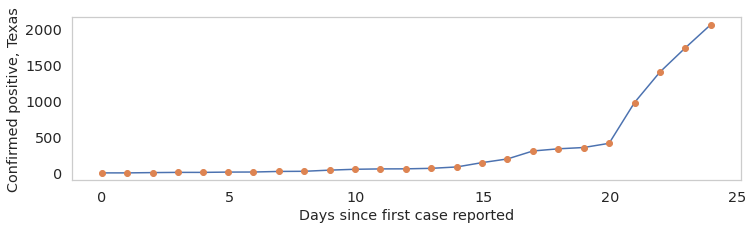

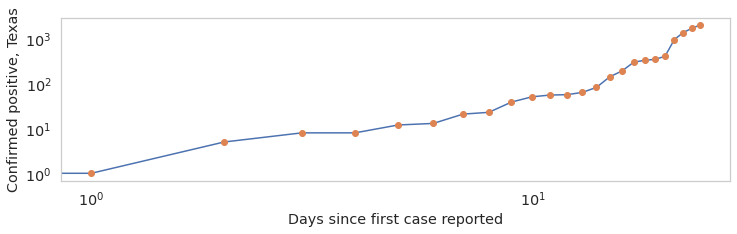

In [288]:


params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12,3),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fig, ax = plt.subplots()
plt.plot(x_data,y_data)
plt.plot(x_data,y_data,'o')
ax.set_xlabel('Days since first case reported')
ax.set_ylabel('Confirmed positive, Texas')
plt.grid()



fig, ax = plt.subplots()
plt.plot(x_data,y_data)
plt.plot(x_data,y_data,'o')

ax.set_xlabel('Days since first case reported')
ax.set_ylabel('Confirmed positive, Texas')
plt.xscale("log")
plt.grid()
plt.yscale("log")

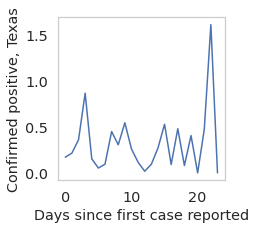

In [289]:


params = {'legend.fontsize': 'x-large',
          'figure.figsize': (3, 3),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

# growth_rate = np.exp(np.diff(np.log(y_data))) - 1

dt = np.diff(x_data)
ds = np.diff(np.log(y_data))

growth_rate = [x/y for x, y in zip(ds,dt)]

fig, ax = plt.subplots()
plt.plot(growth_rate)
# plt.plot(x_data,y_data,'o')
ax.set_xlabel('Days since first case reported')
ax.set_ylabel('Confirmed positive, Texas')
plt.grid()

doubling_time = 70/np.mean(growth_rate)

